# Time Series Anomaly detection

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns
# from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:,.2f}'.format
from fbprophet import Prophet
from datetime import datetime, timedelta
import statsmodels.api as sm
from sklearn.cluster import KMeans
import xgboost as xgb

from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Colab Notebooks/Otros/Connecterra/")

In [4]:
cwd = os.getcwd()

In [5]:
#!ls

In [6]:
file_names = [
              '10261-1540711800.txt' ,  '12497-1540711800.txt',
 '10786-1540711800.txt', '3340-1540711800.txt',
 '10871-1540728000.txt',  '4911-1540711800.txt',
 '11134-1540711800.txt','8512-1540711800.txt',
 '11994-1540711800.txt',  
 '11999-1540711800.txt',  
 '12434-1540728000.txt',   
              ]

In [8]:
df = pd.DataFrame()

for number, file in enumerate(file_names):
  _temp_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Otros/Connecterra/{file}', header = None)
  _temp_df['Person'] = number
  df = pd.concat([df,_temp_df])

In [9]:
df.columns = ['Action1','Action2','Action3','Action4','Useless','Person']

In [10]:
df.drop('Useless', axis = 1 , inplace = True)

In [11]:
df.reset_index(inplace= True,  drop = True)


In [12]:
df.head(5)

,Action1,Action2,Action3,Action4,Person
0,0.15,0.12,0.59,0.13,0
1,0.03,0.73,0.01,0.24,0
2,0.15,0.50,0.01,0.34,0
3,0.06,0.53,0.01,0.40,0
4,0.36,0.45,0.00,0.19,0


## Explore data

We observe that 34% of the time the person is doing Action1, 20% is Action2, 32% Action3 and 14% Action4, on average. All registers range between 0 and 1 (althought max time action2 is 98% and max time action4 is 88%). There are 11 different people in the dataset.

In [13]:
df.describe()

,Action1,Action2,Action3,Action4,Person
count,"66,000.00","66,000.00","66,000.00","66,000.00","66,000.00"
mean,0.34,0.20,0.32,0.14,5.00
std,0.34,0.23,0.34,0.15,3.16
min,-0.02,0.00,0.00,0.00,0.00
25%,0.04,0.02,0.03,0.02,2.00
50%,0.19,0.09,0.12,0.07,5.00
75%,0.61,0.34,0.65,0.23,8.00
max,1.00,0.98,1.00,0.88,10.00


Most registers of Action1 are distributed to the left. However, we also observe large frequencies close to 1, meaning that there are large periods of time while the person is doing Action1.

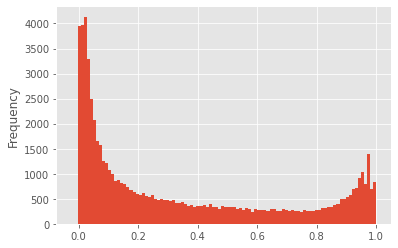

In [14]:
df['Action1'].plot(kind = 'hist', bins = 100)

There are few periods of 15 minutes while the person is doing action2. For most registers, the person never does action2.

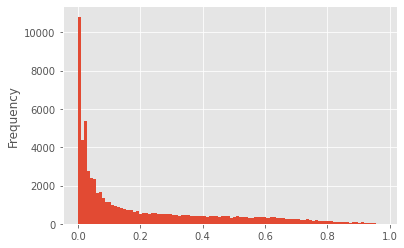

In [15]:
df['Action2'].plot(kind = 'hist', bins = 100)

The distribution of Action3 is more similar to that of doing Action1 althought we do not observe so many periods of 15 minutes when the person is only Action3.

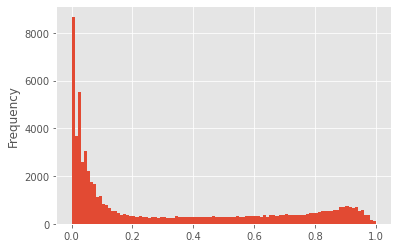

In [16]:
df['Action3'].plot(kind = 'hist', bins = 100)

Similarly to Action2, the person spends few periods on action4 all the 15 minutes.

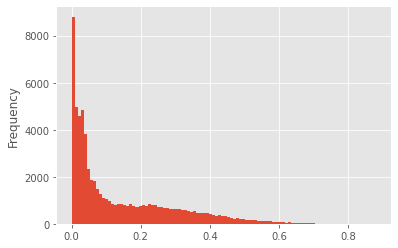

In [17]:
df['Action4'].plot(kind = 'hist', bins = 100)

No data point can be considered an outlier by itself. All datapoints range are between 0-1 (as it is a percentage).
The anomalous behaviour of the person comes from the frequency of each behaviour. Thus, the stationarity of each action is very important.

Moreover, we observe certain actions correlated between them. Generally, Action1 is negatively correlated with the rest of the actions.

In [19]:
df.corr()

,Action1,Action2,Action3,Action4,Person
Action1,1.00,-0.51,-0.52,-0.29,0.08
Action2,-0.51,1.00,-0.39,0.49,-0.17
Action3,-0.52,-0.39,1.00,-0.48,0.00
Action4,-0.29,0.49,-0.48,1.00,0.09
Person,0.08,-0.17,0.00,0.09,1.00


We plot a sample of first person, first day, to start getting a sense of the cycle of activity of the person. There seem to be certain cycles of 20 lags periods.

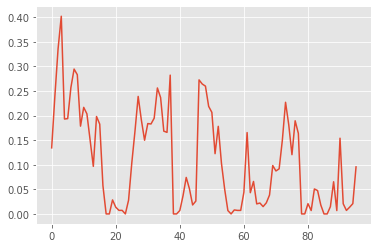

In [23]:
df['Action4'][0:96].plot()

## Feature engineering

We compute certain variables descripting past and mean behaviour. We compute the last 10 lags observations from the current register. We also calculate the Moving Average (lag 3 and lag 5). We will use these variables as regressors for our Machine Learning models.

Moreover, we compute, for each register, the average time spent in the next 3 periods. As we will further discuss, it might be interesting to predict the mean behaviour of the next 3 lags (not only the very first next lag) as the series will be more smooth and the Machine Learning model will easier detect anomalous behaviour.

On following analysis we will observe that most actions are strongly correlated in the past 3 lags. Hence, we compute two MA 3 lags and 5 lags.

The computed lags are done in a for loop for each person so that we do not impute lags of a person on the following person in the dataset.

In [24]:
lag_df = pd.DataFrame()

In [25]:
for pers in range(0,11):
    single_pers_df = pd.DataFrame(index = df[df.Person == pers].index)
    for col in ['Action1','Action2','Action3','Action4']:
        for i in range(1,10):
            single_pers_df[f'{col}_{i}'] = df[df.Person == pers][col].shift(i)
    lag_df = pd.concat([lag_df,single_pers_df], axis = 0)

In [26]:
df = df.join(lag_df)

In [27]:
lag_df = pd.DataFrame()
for pers in range(0,11):
    single_pers_df = pd.DataFrame(index = df[df.Person == pers].index)
    for col in ['Action1','Action2','Action3','Action4']:
        single_pers_df[f'{col}_MA3_b1'] = df[df.Person == pers][col].rolling(window=3).mean()
    lag_df = pd.concat([lag_df,single_pers_df], axis = 0)

In [28]:
df = df.join(lag_df)

In [29]:
lag_df = pd.DataFrame()
for pers in range(0,11):
    single_pers_df = pd.DataFrame(index = df[df.Person == pers].index)
    for col in ['Action1','Action2','Action3','Action4']:
        single_pers_df[f'{col}_MA5_b1'] = df[df.Person == pers][col].rolling(window=5).mean()
    lag_df = pd.concat([lag_df,single_pers_df], axis = 0)

In [30]:
df = df.join(lag_df)

In [31]:
lag_df = pd.DataFrame()
for pers in range(0,11):
    single_pers_df = pd.DataFrame(index = df[df.Person == pers].index)
    for col in ['Action1','Action2','Action3','Action4']:
      single_pers_df[f'{col}_MA3_forward'] = (df[df.Person == pers][col].shift(-3) + df[df.Person == pers][col].shift(-2) + df[df.Person == pers][col].shift(-1))/3
    lag_df = pd.concat([lag_df,single_pers_df], axis = 0)

In [32]:
df = df.join(lag_df)

In [33]:
for col in ['Action1','Action2','Action3','Action4']:
  df[f'{col}_dif'] = df[f'{col}'] - df[f'{col}_1']

In [34]:
df.head(2)

,Action1,Action2,Action3,Action4,Person,Action1_1,Action1_2,Action1_3,Action1_4,Action1_5,Action1_6,Action1_7,Action1_8,Action1_9,Action2_1,Action2_2,Action2_3,Action2_4,Action2_5,Action2_6,Action2_7,Action2_8,Action2_9,Action3_1,Action3_2,Action3_3,Action3_4,Action3_5,Action3_6,Action3_7,Action3_8,Action3_9,Action4_1,Action4_2,Action4_3,Action4_4,Action4_5,Action4_6,Action4_7,Action4_8,Action4_9,Action1_MA3_b1,Action2_MA3_b1,Action3_MA3_b1,Action4_MA3_b1,Action1_MA5_b1,Action2_MA5_b1,Action3_MA5_b1,Action4_MA5_b1,Action1_MA3_forward,Action2_MA3_forward,Action3_MA3_forward,Action4_MA3_forward,Action1_dif,Action2_dif,Action3_dif,Action4_dif
0,0.15,0.12,0.59,0.13,0,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.08,0.59,0.01,0.33,nan,nan,nan,nan
1,0.03,0.73,0.01,0.24,0,0.15,nan,nan,nan,nan,nan,nan,nan,nan,0.12,nan,nan,nan,nan,nan,nan,nan,nan,0.59,nan,nan,nan,nan,nan,nan,nan,nan,0.13,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.19,0.49,0.01,0.31,-0.12,0.60,-0.58,0.11


In [35]:
df_non_null = df.dropna().copy()

## Time series descriptive exploration

Another approach that we will explore is that of predicting changes in behaviour. The idea is to detect anomalous behaviour, not because the person is doing an action for a too long period of time but because we detect too sudden changes in behaviour.

We need to drop null registers (we have created some after computing lags)

In [36]:
df_non_null.head(1)

,Action1,Action2,Action3,Action4,Person,Action1_1,Action1_2,Action1_3,Action1_4,Action1_5,Action1_6,Action1_7,Action1_8,Action1_9,Action2_1,Action2_2,Action2_3,Action2_4,Action2_5,Action2_6,Action2_7,Action2_8,Action2_9,Action3_1,Action3_2,Action3_3,Action3_4,Action3_5,Action3_6,Action3_7,Action3_8,Action3_9,Action4_1,Action4_2,Action4_3,Action4_4,Action4_5,Action4_6,Action4_7,Action4_8,Action4_9,Action1_MA3_b1,Action2_MA3_b1,Action3_MA3_b1,Action4_MA3_b1,Action1_MA5_b1,Action2_MA5_b1,Action3_MA5_b1,Action4_MA5_b1,Action1_MA3_forward,Action2_MA3_forward,Action3_MA3_forward,Action4_MA3_forward,Action1_dif,Action2_dif,Action3_dif,Action4_dif
9,0.31,0.50,0.01,0.18,0,0.35,0.45,0.07,0.65,0.36,0.06,0.15,0.03,0.15,0.33,0.22,0.65,0.15,0.45,0.53,0.50,0.73,0.12,0.03,0.04,0.03,0.01,0.00,0.01,0.01,0.01,0.59,0.28,0.29,0.26,0.19,0.19,0.40,0.34,0.24,0.13,0.37,0.35,0.03,0.25,0.37,0.37,0.02,0.24,0.38,0.32,0.10,0.19,-0.04,0.16,-0.01,-0.10


The distribution of each variable is bounded between 0 and 1. Moreover, for a given period, the % of the 4 actions sums up to 1. From the graph below, we observe that past behaviour could affect present behaviour of a certain action. Therefore, it might be interesting to include lags of other actions to predict a specific action.

In [37]:
df_non_null.corr()

,Action1,Action2,Action3,Action4,Person,Action1_1,Action1_2,Action1_3,Action1_4,Action1_5,Action1_6,Action1_7,Action1_8,Action1_9,Action2_1,Action2_2,Action2_3,Action2_4,Action2_5,Action2_6,Action2_7,Action2_8,Action2_9,Action3_1,Action3_2,Action3_3,Action3_4,Action3_5,Action3_6,Action3_7,Action3_8,Action3_9,Action4_1,Action4_2,Action4_3,Action4_4,Action4_5,Action4_6,Action4_7,Action4_8,Action4_9,Action1_MA3_b1,Action2_MA3_b1,Action3_MA3_b1,Action4_MA3_b1,Action1_MA5_b1,Action2_MA5_b1,Action3_MA5_b1,Action4_MA5_b1,Action1_MA3_forward,Action2_MA3_forward,Action3_MA3_forward,Action4_MA3_forward,Action1_dif,Action2_dif,Action3_dif,Action4_dif
Action1,1.00,-0.51,-0.52,-0.29,0.08,0.49,0.00,-0.16,-0.07,0.04,0.07,0.05,0.01,-0.00,-0.28,-0.12,-0.09,-0.11,-0.10,-0.06,-0.02,-0.01,-0.01,-0.23,0.15,0.29,0.20,0.06,-0.02,-0.03,-0.01,0.01,-0.17,-0.15,-0.15,-0.12,-0.07,-0.02,0.01,0.00,-0.00,0.67,-0.36,-0.26,-0.24,0.44,-0.30,-0.04,-0.24,0.15,-0.24,0.15,-0.23,0.50,-0.29,-0.31,-0.15
Action2,-0.51,1.00,-0.39,0.49,-0.17,-0.35,-0.18,-0.08,-0.03,0.00,0.01,0.01,0.00,-0.00,0.68,0.40,0.23,0.14,0.07,0.03,0.01,-0.00,-0.01,-0.29,-0.21,-0.15,-0.09,-0.05,-0.01,0.01,0.03,0.04,0.41,0.27,0.15,0.06,-0.00,-0.04,-0.06,-0.07,-0.07,-0.47,0.81,-0.39,0.46,-0.40,0.65,-0.38,0.37,-0.22,0.51,-0.34,0.33,-0.16,0.40,-0.11,0.10
Action3,-0.52,-0.39,1.00,-0.48,0.00,-0.12,0.21,0.25,0.10,-0.05,-0.10,-0.07,-0.03,-0.01,-0.38,-0.27,-0.12,0.01,0.06,0.07,0.05,0.04,0.05,0.57,0.07,-0.14,-0.11,-0.01,0.04,0.02,-0.02,-0.04,-0.40,-0.21,-0.06,0.02,0.04,0.03,0.03,0.03,0.04,-0.19,-0.41,0.70,-0.43,-0.03,-0.31,0.46,-0.31,0.09,-0.25,0.21,-0.23,-0.39,-0.01,0.47,-0.10
Action4,-0.29,0.49,-0.48,1.00,0.09,-0.28,-0.20,-0.10,-0.02,0.03,0.04,0.04,0.03,0.02,0.44,0.27,0.13,0.03,-0.03,-0.06,-0.07,-0.08,-0.08,-0.31,-0.17,-0.10,-0.06,-0.04,-0.02,0.00,0.02,0.02,0.66,0.41,0.25,0.14,0.06,0.03,0.02,0.02,0.03,-0.35,0.47,-0.42,0.81,-0.31,0.36,-0.37,0.66,-0.21,0.32,-0.29,0.52,-0.01,0.06,-0.19,0.41
Person,0.08,-0.17,0.00,0.09,1.00,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,-0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.11,-0.21,0.00,0.10,0.14,-0.23,0.00,0.12,0.11,-0.20,0.00,0.10,0.00,-0.00,-0.00,0.00
Action1_1,0.49,-0.35,-0.12,-0.28,0.08,1.00,0.49,0.00,-0.16,-0.07,0.04,0.07,0.05,0.01,-0.51,-0.28,-0.12,-0.09,-0.11,-0.10,-0.06,-0.02,-0.01,-0.52,-0.23,0.15,0.29,0.20,0.06,-0.02,-0.03,-0.01,-0.29,-0.17,-0.15,-0.15,-0.12,-0.07,-0.02,0.01,0.00,0.89,-0.45,-0.37,-0.29,0.64,-0.36,-0.14,-0.28,-0.10,-0.11,0.24,-0.12,-0.50,0.20,0.42,0.01
Action1_2,0.00,-0.18,0.21,-0.20,0.08,0.49,1.00,0.49,0.00,-0.16,-0.07,0.04,0.07,0.05,-0.35,-0.51,-0.28,-0.12,-0.09,-0.11,-0.10,-0.06,-0.02,-0.12,-0.52,-0.23,0.15,0.29,0.20,0.06,-0.02,-0.03,-0.28,-0.29,-0.17,-0.15,-0.15,-0.12,-0.07,-0.02,0.01,0.67,-0.41,-0.19,-0.30,0.69,-0.39,-0.17,-0.29,-0.08,-0.04,0.13,-0.04,-0.49,0.21,0.36,0.11
Action1_3,-0.16,-0.08,0.25,-0.10,0.08,0.00,0.49,1.00,0.49,0.00,-0.16,-0.07,0.04,0.07,-0.18,-0.35,-0.51,-0.28,-0.12,-0.09,-0.11,-0.10,-0.06,0.21,-0.12,-0.52,-0.23,0.15,0.29,0.20,0.06,-0.02,-0.20,-0.28,-0.29,-0.17,-0.15,-0.15,-0.12,-0.07,-0.02,0.15,-0.24,0.15,-0.23,0.64,-0.37,-0.13,-0.28,0.02,-0.01,-0.02,0.02,-0.15,0.13,0.04,0.12
Action1_4,-0.07,-0.03,0.10,-0.02,0.08,-0.16,0.00,0.49,1.00,0.49,0.00,-0.16,-0.07,0.04,-0.08,-0.18,-0.35,-0.51,-0.28,-0.12,-0.09,-0.11,-0.10,0.25,0.21,-0.12,-0.52,-0.23,0.15,0.29,0.20,0.06,-0.10,-0.20,-0.28,-0.29,-0.17,-0.15,-0.15,-0.12,-0.07,-0.10,-0.11,0.24,-0.12,0.44,-0.31,-0.03,-0.24,0.07,0.01,-0.10,0.04,0.08,0.07,-0.17,0.09
Action1_5,0.04,0.00,-0.05,0.03,0.08,-0.07,-0.16,0.00,0.49,1.00,0.49,0.00,-0.16,-0.07,-0.03,-0.08,-0.18,-0.35,-0.51,-0.28,-0.12,-0.09,-0.11,0.10,0.25,0.21,-0.12,-0.52,-0.23,0.15,0.29,0.20,-0.02,-0.10,-0.20,-0.28,-0.29,-0.17,-0.15,-0.15,-0.12,-0.08,-0.04,0.13,-0.04,0.11,-0.17,0.13,-0.15,0.06,0.01,-0.09,0.04,0.11,0.03,-0.16,0.06


We observe that doing Action1 at time t is negatively correlated with the rest of the actions at time t. Meaning that we should observe that as a person is doing more of Action1 in a 15 minutes period, less will be doing of the rest. However, Action2 and Action4 are positively correlated. 

There are also some high correlations between an action and lags of other actions: 
* Action 4 and Action1 lag 1: corr = -0.28
* Action 2 and Action 4 lag 1: +0.41

Meaning that thy might be good atributes to predict current behaviour.

By observing the correlation between the difference of the action and the action itself, we observe a positive and high correlation. This correlation is higher for the action1/action1_dif (50%), meaning that when we observe large values of doing action1, we come from higher differences from the last period. That is to say, there are more sudden changes compared to Action2 and Action2_dif (correlation 40%).

We plot the distribution of the difference of Action3. We can observe that most periods there are low changes in the action. However, for some periods, there are large changes. The distribution might be close to a t-student. Further analysis will be explored.

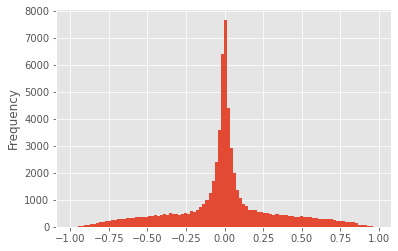

In [39]:
df['Action3_dif'].plot(kind = 'hist', bins = 100)

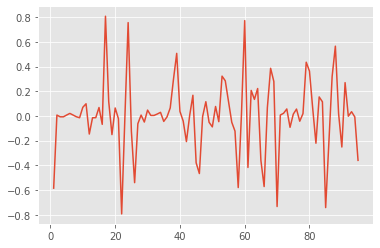

In [40]:
df['Action3_dif'][0:96].plot()

We generally observe periods of low variance followed by periods of higher variance. Hence, it does not seem to be a series generated by whithe noise (which could not be predicted)

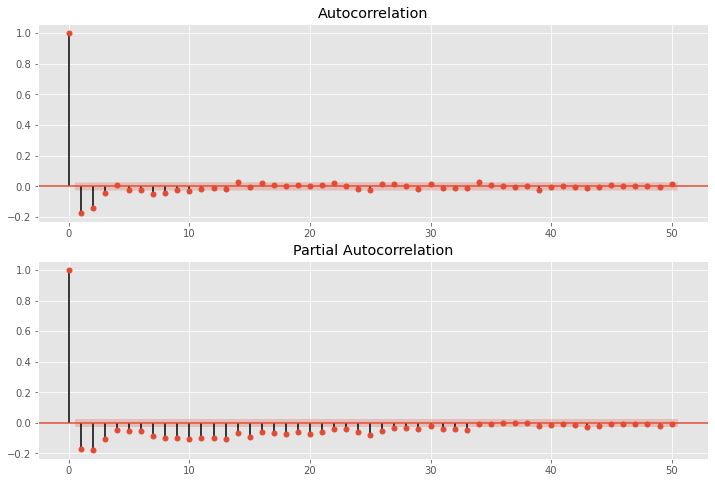

In [41]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_non_null['Action2_dif'].loc[0:6000].squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_non_null['Action2_dif'].loc[0:6000], lags=50, ax=ax2)

Moreover, we observe certain correlation between lags of the difference. Hence, we can be sure the series is not generated by random noise and it can be predicted.

Action3 at time t is significantly correlated with the first 3 lags.
From partial autocorrelation function we also observe a correlation every 10 lags, which might indicate certain cycle in activity every 150 min
At around lag 96 we also observe certain correlation with current behaviour, which coincides with a 24 hours cycle. (96lags x15 min = 24 hours)

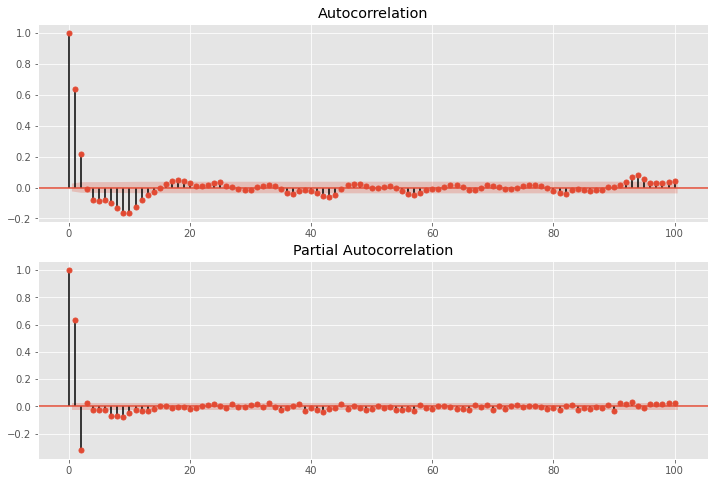

In [42]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Action3'].loc[0:6000].squeeze(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Action3'].loc[0:6000], lags=100, ax=ax2)

We smooth the series in order to find more easily anomalous behaviours. 
We can also observe that PACF smoothly decays towards 0 having two lags of positive correlation followed with a lag of negative correlation

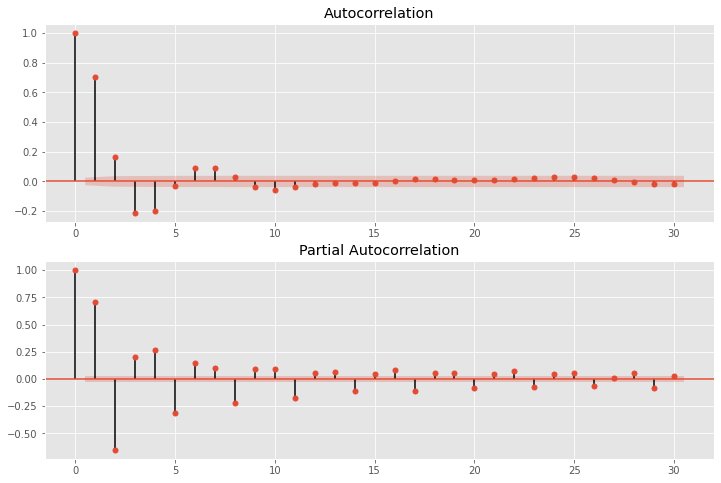

In [44]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_non_null['Action1_MA3_forward'].loc[0:6000].squeeze(), lags=30, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_non_null['Action1_MA3_forward'].loc[0:6000], lags=30, ax=ax2)

We also want to test stationarity of the data. It is highly probable that the data is stationary because the range of the variable is between 0 and 1

In [45]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df['Action3'].loc[0:6000].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -27.089368
p-value: 0.000000


From the p-value, we can conclude that Action3 is stationary

## T-student approximation for detecting outliers in behavioural changes

Our first approach to detect anomalies is to estimate the distribution of the changes ina person's action. Once we now the underlying distribution of the data, it is easy to spot values that are very unlikely to happen. A certain threshold can be adjusted and anomalous behaviour can be detected. 

In [46]:
stats.t.fit(df_non_null['Action3_dif'])

(0.9607188624372452, -0.000601366328783679, 0.08989174608947231)

0.96 degrees of freedom, centered around 0 and scale equals to 0.09

This approach will help into understanding situations in which the person suddenly changes an action. It could be an external factor that generates the person suddenly stopping action2. However, if we repeatedly observe rapid changes of behaviour, it could be that the person is under high stress causing it to have a disruptive behaviour.

## ARIMA model

A more consistent approach consists on considering each action isolated. Althought the % of time spend on an action affects other actions. 
The objective is to be able to predict the series of actions. For each period we will have a prediction and a confidence interval that will help us detect anomalous registers.
Moreover, the models learns typical patterns. Hence, if we predict a value very different from reality, we might be observing some problem on the person. 

We choose an ARIMA model. Parameter d=0 as we have not observed a trend in the time series (althought differentiating the series might help detecting anomalous behaviour). From ACF and PACF plots, we can observe that around 10 to 12 lags before the action is correlated with itself (ACF). That is to say, the person might have cycles of actions of around 150 min - 180 min. Moreover ACF decays more slowly. Hence, it seems to be a stronger AR component. In conseqence, we set a larger parametr for AR than MA.

In [48]:
from statsmodels.tsa.arima_model import ARIMA

In [49]:
model = ARIMA(df['Action3'].loc[0:6000], order=(12,0,3))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



                              ARMA Model Results                              
Dep. Variable:                Action3   No. Observations:                 6001
Model:                    ARMA(12, 3)   Log Likelihood                -433.663
Method:                       css-mle   S.D. of innovations              0.260
Date:                Mon, 24 Jan 2022   AIC                            901.326
Time:                        21:23:58   BIC                           1015.221
Sample:                             0   HQIC                           940.878
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3389      0.004     76.456      0.000       0.330       0.348
ar.L1.Action3      0.1247      0.108      1.159      0.246      -0.086       0.336
ar.L2.Action3      0.3734      0.070

AR lags are signifcant up to lag 9 and MA lags 1 and 3 are also significant.

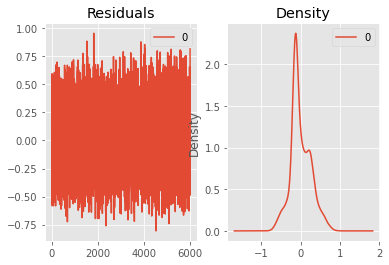

In [50]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The model seems to have a systematic underestimation of the predicted values ans the errors' mean is slightly skewed to the left.

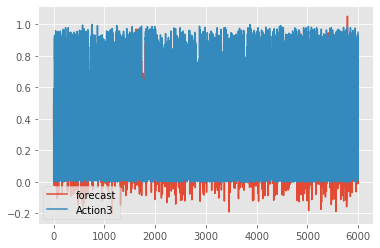

In [51]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

In [52]:
model_fit.predict()

0       0.34
1       0.50
2      -0.02
3       0.18
4       0.15
        ... 
5996    0.23
5997    0.15
5998    0.16
5999    0.14
6000    0.13
Length: 6001, dtype: float64

In [53]:
def bootstrap_prediction_interval(y_train,
                                  y_fit,
                                  y_pred_value,
                                  alpha = 0.05,
                                  nbootstrap = None,
                                  seed= None):

    # get number of samples
    n = len(y_train)

    # compute the forecast errors/resid
    fe = y_train - y_fit

    # get percentile bounds
    percentile_lower = (alpha * 100) / 2
    percentile_higher = 100 - percentile_lower

    if nbootstrap is None:
        nbootstrap = np.sqrt(n).astype(int)
    if seed is None:
        rng = np.random.default_rng()
    else:
        rng = np.random.default_rng(seed)

    # bootstrap sample from errors
    error_bootstrap = []
    for _ in range(nbootstrap):
        idx = rng.integers(low=n)
        error_bootstrap.append(fe[idx])

    # get lower and higher percentiles of sampled forecast errors
    fe_lower = np.percentile(a=error_bootstrap, q=percentile_lower)
    fe_higher = np.percentile(a=error_bootstrap, q=percentile_higher)

    # compute P.I.
    pi = pd.DataFrame([y_pred_value + fe_lower, y_pred_value, y_pred_value + fe_higher]).T
   
    return pi

After further improvement of the model, we can also compute a confidence interval on the estimation. From the distribution of the errors, we computed bootstarpped samples in order to calculate confidence intervals on the predictions.

In [54]:
bootstrap_prediction_interval(df['Action3'].loc[0:6000],model_fit.predict(),model_fit.predict()).head(5)

,0,1,2
0,-0.20,0.34,0.91
1,-0.04,0.50,1.07
2,-0.56,-0.02,0.55
3,-0.36,0.18,0.75
4,-0.39,0.15,0.72


With these results we can detect anomalous registers if they are out of the confidence interval.

There is also a major drawback on using ARIMA model. We need to train a model for each person (we cannot simply stack one register after the other)

## Prophet prediction

An improvement of the ARIMA model could be Prophet algorithm from Meta. Prophet is a model that accounts for trend and seasonality. In our case, trend is not important but there is strong seasonality in our time series.
Moreover, Prophet allows to include regressors in the model. Therefore, we can include lags of other actions to better predict anomalous behaviour.

In [55]:
datetime(2021, 1, 1)

datetime.datetime(2021, 1, 1, 0, 0)

In [56]:
date_list = [datetime(2021, 1, 1) + timedelta(minutes=15*x) for x in range(0, 6000)]

In [57]:
ds = [i.strftime('%Y-%m-%d %H:%M:%S') for i in date_list]

In [59]:
feature = 'Action3_dif'

dfNew = pd.DataFrame()
dfNew['ds'] = ds
dfNew['y'] = df[df['Person']==1][[feature]].reset_index(drop = True).copy()

In [60]:
for col in ['Action1','Action2','Action3','Action4']:
  for i in range(1,15):
    dfNew[f'{col}_{i}'] = df[df['Person']==1][col].shift(i).reset_index(drop = True)

In [61]:
dfNew.dropna(inplace = True)

In [62]:
dfNew.tail(1)

,ds,y,Action1_1,Action1_2,Action1_3,Action1_4,Action1_5,Action1_6,Action1_7,Action1_8,Action1_9,Action1_10,Action1_11,Action1_12,Action1_13,Action1_14,Action2_1,Action2_2,Action2_3,Action2_4,Action2_5,Action2_6,Action2_7,Action2_8,Action2_9,Action2_10,Action2_11,Action2_12,Action2_13,Action2_14,Action3_1,Action3_2,Action3_3,Action3_4,Action3_5,Action3_6,Action3_7,Action3_8,Action3_9,Action3_10,Action3_11,Action3_12,Action3_13,Action3_14,Action4_1,Action4_2,Action4_3,Action4_4,Action4_5,Action4_6,Action4_7,Action4_8,Action4_9,Action4_10,Action4_11,Action4_12,Action4_13,Action4_14
5999,2021-03-04 11:45:00,0.22,0.96,0.70,0.12,0.06,0.76,0.37,0.60,0.59,0.05,0.05,0.14,0.03,0.06,0.07,0.01,0.01,0.05,0.02,0.04,0.25,0.15,0.14,0.61,0.66,0.46,0.64,0.59,0.27,0.01,0.24,0.78,0.90,0.16,0.15,0.04,0.01,0.07,0.10,0.14,0.07,0.12,0.53,0.01,0.04,0.06,0.01,0.04,0.22,0.21,0.26,0.27,0.19,0.25,0.26,0.24,0.12


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



Forcasted  Action3_dif values 
                       ds  yhat  yhat_lower  yhat_upper
5981 2021-03-04 10:45:00  0.01       -0.32        0.31
5982 2021-03-04 11:00:00 -0.02       -0.32        0.28
5983 2021-03-04 11:15:00 -0.02       -0.33        0.27
5984 2021-03-04 11:30:00 -0.04       -0.32        0.24
5985 2021-03-04 11:45:00  0.05       -0.26        0.33



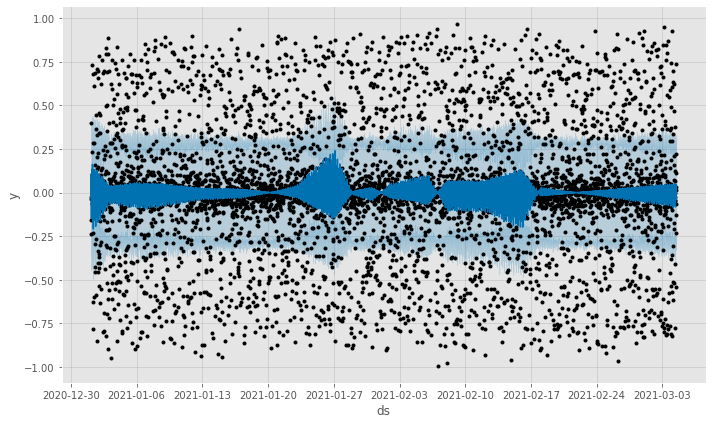

In [63]:
m1 = Prophet(daily_seasonality=True, seasonality_mode = 'multiplicative', seasonality_prior_scale = 50, changepoint_prior_scale = 0.5, interval_width = 0.6 )
m1.add_seasonality(name='day', period=0.01, fourier_order=20, mode = 'multiplicative', prior_scale=50 )
m1.add_regressor('Action2_1')
m1.fit(dfNew)
horizon= 0
future = m1.make_future_dataframe(periods=horizon)
future['Action2_1'] = dfNew['Action2_1'].reset_index(drop = True)
forecast = m1.predict(future)
print('\nForcasted  {} values \n {}\n'.format(feature, forecast[['ds',  'yhat', 'yhat_lower', 'yhat_upper']].tail()))
fig1 = m1.plot(forecast)

In [64]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Action2_1,Action2_1_lower,Action2_1_upper,cow_day,cow_day_lower,cow_day_upper,daily,daily_lower,daily_upper,extra_regressors_multiplicative,extra_regressors_multiplicative_lower,extra_regressors_multiplicative_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
5981,2021-03-04 10:45:00,-0.00,-0.32,0.31,-0.00,-0.00,-0.24,-0.24,-0.24,-3.35,-3.35,-3.35,-0.15,-0.15,-0.15,-0.24,-0.24,-0.24,-3.27,-3.27,-3.27,0.46,0.46,0.46,0.00,0.00,0.00,0.01
5982,2021-03-04 11:00:00,-0.00,-0.32,0.28,-0.00,-0.00,-0.26,-0.26,-0.26,2.30,2.30,2.30,-0.14,-0.14,-0.14,-0.26,-0.26,-0.26,2.35,2.35,2.35,0.46,0.46,0.46,0.00,0.00,0.00,-0.02
5983,2021-03-04 11:15:00,-0.00,-0.33,0.27,-0.00,-0.00,-0.22,-0.22,-0.22,3.24,3.24,3.24,-0.12,-0.12,-0.12,-0.22,-0.22,-0.22,3.35,3.35,3.35,0.45,0.45,0.45,0.00,0.00,0.00,-0.02
5984,2021-03-04 11:30:00,-0.00,-0.32,0.24,-0.00,-0.00,-0.27,-0.27,-0.27,7.64,7.64,7.64,-0.09,-0.09,-0.09,-0.27,-0.27,-0.27,7.72,7.72,7.72,0.45,0.45,0.45,0.00,0.00,0.00,-0.04
5985,2021-03-04 11:45:00,-0.00,-0.26,0.33,-0.00,-0.00,-0.28,-0.28,-0.28,-11.03,-11.03,-11.03,-0.05,-0.05,-0.05,-0.28,-0.28,-0.28,-10.91,-10.91,-10.91,0.44,0.44,0.44,0.00,0.00,0.00,0.05


In [65]:
df[df['Person']==1][[feature]].tail()

,Action3_dif
11995,0.74
11996,-0.13
11997,-0.54
11998,-0.23
11999,0.22


The underlying assumption of the model is similar to ARIMA. It also detects anomalous behaviour by predicting the next value and computing confidence intervals.

## K-means clustering


Now we want to understand the anomaly behaviour form another perspective. 
Instead of looking at the behaviour of the person isolated , we will look at clusters of combined behaviour.

This approach might improve our models in three directions:
    
   * The mathematical idea of the algorithm is completely different. Instead of looking at statistically significant outliers or predictions out of range, we will cluster typical behaviours and compute distances.
    
   * It also allows to aggregate registers of different persons and consider it as one single dataset.
    
   * This type of model allows for cold starts, meaning that if a new person comes, we do not need to wait for having enough registers to build a model.
   
   * It also allows to spot typical combined actions in a certain period of time.

We will cluster behaviours based on current % for each action together with an aggregation of past 3 lags. 

In [70]:
vars_list = ['Action1', 'Action2', 'Action3', 'Action4', 'Action1_1',
        'Action2_1',  'Action3_1',  'Action4_1',
       'Action1_MA3_b1', 'Action2_MA3_b1', 'Action3_MA3_b1', 'Action4_MA3_b1',
       'Action1_MA5_b1', 'Action2_MA5_b1', 'Action3_MA5_b1', 'Action4_MA5_b1'
      ]

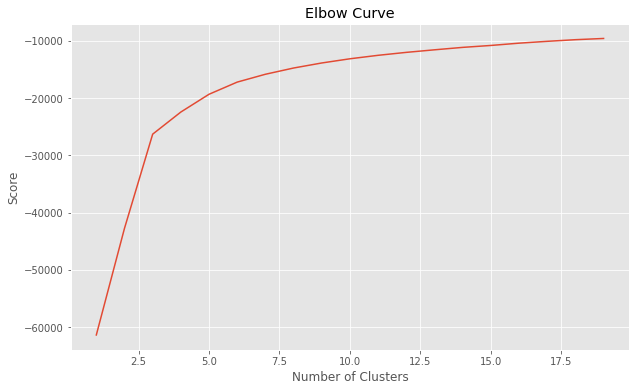

In [71]:
X = df_non_null[vars_list]

n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(X) for i in n_cluster]
scores = [kmeans[i].score(X) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [72]:
X = X.reset_index(drop=True)
km = KMeans(n_clusters=5)
km.fit(X)
km.predict(X)
labels = km.labels_

In [73]:
X['Label'] = labels

In [74]:
X['Label'].value_counts()

0    21314
2    14495
3    12775
1     9218
4     8066
Name: Label, dtype: int64

Once we cluster each observation, we can compute the distance of each register to the centroid of its cluster. We then set a threshold of top furthest points from centroid. We consider that those points are more abnormal.

In [75]:
def getDistanceByPoint(data, model):
    distance = []
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.append(np.linalg.norm(Xa-Xb))
    return distance

In [76]:
distances = getDistanceByPoint(X[vars_list], km)

In [77]:
outliers_fraction = 0.01
number_of_outliers = int(outliers_fraction*len(distances))

In [78]:
sorted_dist = sorted(distances)

In [79]:
number_of_outliers

658

In [80]:
threshold = sorted_dist[len(distances)-number_of_outliers]

In [81]:
X['Anomalous'] = (distances >= threshold).astype(int)

In [87]:
X[(X.Anomalous == 1)].head()

,Action1,Action2,Action3,Action4,Action1_1,Action2_1,Action3_1,Action4_1,Action1_MA3_b1,Action2_MA3_b1,Action3_MA3_b1,Action4_MA3_b1,Action1_MA5_b1,Action2_MA5_b1,Action3_MA5_b1,Action4_MA5_b1,Label,Anomalous
4131,0.99,0.01,0.00,0.00,0.98,0.01,0.01,0.00,0.97,0.02,0.00,0.00,0.87,0.04,0.01,0.07,3,1
6780,0.96,0.02,0.01,0.01,0.99,0.00,0.00,0.01,0.96,0.01,0.01,0.01,0.80,0.14,0.01,0.04,3,1
6781,0.97,0.01,0.00,0.02,0.96,0.02,0.01,0.01,0.97,0.01,0.00,0.02,0.97,0.01,0.01,0.01,3,1
6830,0.95,0.01,0.01,0.04,0.92,0.01,0.04,0.04,0.95,0.01,0.01,0.03,0.95,0.01,0.01,0.02,3,1
9444,0.96,0.02,0.00,0.01,0.90,0.03,0.01,0.06,0.94,0.02,0.01,0.03,0.95,0.02,0.01,0.02,3,1


In clustering algorithms, it is important to decide the number of clusters together with the business. Each cluster should characterize a typical behaviour of the person. The number of possible behavious will be better known by the customer.

## XGBoost

Finally, we use an XGBoost model to predict anomalies. The advantages of using a decision tree based model are siilar to the ones of K-Means. 

* It helps with cold starts.
* It allows to use all the dataset together.
* Lags and MA of the action and rest of the actions can be used as attributes.

Moreover, the underlying mathematics of decision tree algorithms are different from K-Means (K-Means computes distances while Decision Trees compute Information Gains and reduces entropy). Therefore, the two models might be able to spot different anomalies in a person behaviour.

The decision tree has several advantages too. It supports the introduction of many predictors, meaning that we could easily include demographic information  Furthermore, XGBoost is very robust to outliers. Althought we have anomalous behaviour in the dataset, the predictions for a certain subpopulation will not be extremely biased by these observation and it will still be possible to detect the anomalies.

In [88]:
df_xgb = df.copy()

In [89]:
df_xgb.dropna(inplace=True)

In [90]:
df_xgb.columns

Index(['Action1', 'Action2', 'Action3', 'Action4', 'Person', 'Action1_1',
       'Action1_2', 'Action1_3', 'Action1_4', 'Action1_5', 'Action1_6',
       'Action1_7', 'Action1_8', 'Action1_9', 'Action2_1', 'Action2_2',
       'Action2_3', 'Action2_4', 'Action2_5', 'Action2_6', 'Action2_7',
       'Action2_8', 'Action2_9', 'Action3_1', 'Action3_2', 'Action3_3',
       'Action3_4', 'Action3_5', 'Action3_6', 'Action3_7', 'Action3_8',
       'Action3_9', 'Action4_1', 'Action4_2', 'Action4_3', 'Action4_4',
       'Action4_5', 'Action4_6', 'Action4_7', 'Action4_8', 'Action4_9',
       'Action1_MA3_b1', 'Action2_MA3_b1', 'Action3_MA3_b1', 'Action4_MA3_b1',
       'Action1_MA5_b1', 'Action2_MA5_b1', 'Action3_MA5_b1', 'Action4_MA5_b1',
       'Action1_MA3_forward', 'Action2_MA3_forward', 'Action3_MA3_forward',
       'Action4_MA3_forward', 'Action1_dif', 'Action2_dif', 'Action3_dif',
       'Action4_dif'],
      dtype='object')

In [91]:
non_future_vars_pred_eat = ['Action1',  'Person', 'Action1_1',
       'Action1_2', 'Action1_3', 'Action1_4', 'Action1_5', 'Action1_6',
       'Action1_7', 'Action1_8', 'Action1_9', 'Action2_1', 'Action2_2',
       'Action2_3', 'Action2_4', 'Action2_5', 'Action2_6', 'Action2_7',
       'Action2_8', 'Action2_9', 'Action3_1', 'Action3_2', 'Action3_3',
       'Action3_4', 'Action3_5', 'Action3_6', 'Action3_7', 'Action3_8',
       'Action3_9', 'Action4_1', 'Action4_2', 'Action4_3', 'Action4_4',
       'Action4_5', 'Action4_6', 'Action4_7', 'Action4_8', 'Action4_9',
       'Action1_MA3_b1', 'Action2_MA3_b1', 'Action3_MA3_b1', 'Action4_MA3_b1',
       'Action1_MA5_b1', 'Action2_MA5_b1', 'Action3_MA5_b1', 'Action4_MA5_b1',
       'Action1_MA3_forward', 'Action2_MA3_forward', 'Action3_MA3_forward',
       'Action4_MA3_forward', 'Action1_dif', 'Action2_dif', 'Action3_dif',
       'Action4_dif']

In [92]:
df_xgb = df_xgb[non_future_vars_pred_eat]

In [93]:
df_xgb.head(1)

,Action1,Person,Action1_1,Action1_2,Action1_3,Action1_4,Action1_5,Action1_6,Action1_7,Action1_8,Action1_9,Action2_1,Action2_2,Action2_3,Action2_4,Action2_5,Action2_6,Action2_7,Action2_8,Action2_9,Action3_1,Action3_2,Action3_3,Action3_4,Action3_5,Action3_6,Action3_7,Action3_8,Action3_9,Action4_1,Action4_2,Action4_3,Action4_4,Action4_5,Action4_6,Action4_7,Action4_8,Action4_9,Action1_MA3_b1,Action2_MA3_b1,Action3_MA3_b1,Action4_MA3_b1,Action1_MA5_b1,Action2_MA5_b1,Action3_MA5_b1,Action4_MA5_b1,Action1_MA3_forward,Action2_MA3_forward,Action3_MA3_forward,Action4_MA3_forward,Action1_dif,Action2_dif,Action3_dif,Action4_dif
9,0.31,0,0.35,0.45,0.07,0.65,0.36,0.06,0.15,0.03,0.15,0.33,0.22,0.65,0.15,0.45,0.53,0.50,0.73,0.12,0.03,0.04,0.03,0.01,0.00,0.01,0.01,0.01,0.59,0.28,0.29,0.26,0.19,0.19,0.40,0.34,0.24,0.13,0.37,0.35,0.03,0.25,0.37,0.37,0.02,0.24,0.38,0.32,0.10,0.19,-0.04,0.16,-0.01,-0.10


We can easily split the dataset in order to train the model. Later, we will check the predictions to ensure it generally predicts correctly. It is important that the XGBoost does not generate overfitting. It would then have learned too specific rules (probably some related to anomalous behaviour) and it would generally predict wrongly, even for non anomalous actions.

In [94]:
train = df_xgb[df_xgb['Person'] < 8]
test = df_xgb[df_xgb['Person'] >= 8]

In [95]:
train.shape

(47904, 54)

In [96]:
test.shape

(17964, 54)

In [97]:
X_train = train.drop(['Action1'], axis = 1)
y_train = train[['Action1']]

X_test = test.drop(['Action1'], axis = 1)
y_test = test[['Action1']]

In [98]:
first_model = xgb.XGBRegressor(random_state=42, n_estimators=80, max_depth=3)
first_model.fit(X_train, y_train)

[21:52:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=80, random_state=42)

In [99]:
test_predictions = pd.DataFrame(first_model.predict(X_test), columns=['Prediction'], index=X_test.index)

In [100]:
results_df = y_test.join(test_predictions)

In [101]:
results_df.columns = ['Target', 'Prediction']
results_df['error'] = results_df['Target'] - results_df['Prediction']

In [102]:
results_df

,Target,Prediction,error
48009,0.64,0.66,-0.02
48010,0.07,0.06,0.01
48011,0.14,0.13,0.01
48012,0.13,0.09,0.04
48013,0.17,0.12,0.05
...,...,...,...
65992,0.14,0.11,0.03
65993,0.64,0.64,0.00
65994,0.72,0.70,0.02
65995,0.07,0.08,-0.00


In [103]:
np.abs(results_df['error']).mean()

0.028998777350152192

The model seems to be very precise at test

In [104]:
top_features = pd.Series(first_model.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

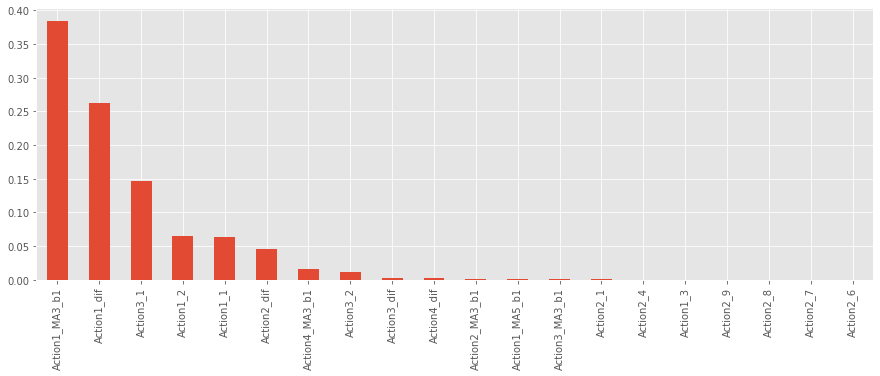

In [105]:
plt.figure(figsize=(15,5))
top_features.plot(kind='bar')

The plot of feature importances helps to detect which variables are more relevant to predict the current behaviour of a person.

Finally, we can conclude that there is no a single approach to this problem. As it is an unsupervised task, it is more recommendable to ensemble different models, wtih different mathematical natures, in order to capture all the complexity of the reality. In further research, we could start checking the predicted results with feedback from our customers to fine tune the models or even select a single of them.

There are also some improvements that, with some extra time, could be done on the current work:
 * add external data
 * As we have discused, cross validate the models with labeled data from the business.
 * Statistically, there are some work to be done. We can generate confidence interval for xgboost by bootstrapping samples of the dataset and generate multiple models for the same prediction. With different predictions, we can generate these confidence intervals of each new observation which would be needed to detect outliers.
 * We have not explored in detail the possibility of predicting differences in actions or Moving Averages. These time series are relatively more smooth and have less sudden changes, meaning that are more easy to predict and extreme vaues already spot anomalous behaviour.
 * There are other algorithms that could be tested: VAR model as an improvement of ARIMA model as it accounts for lags of other variables (the rest of the actions), Isolated Tree methods are based on a similar approach of XGBoost for unsupervised ML.

References:

The definition of the getDistanceByPoint and bootstrap_prediction_interval are taken from StackOverFlow